In [1]:
# Explore features that may be indicative of convergence possibility of a pair

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from Archive.utilities import *
from Archive.features import *

ModuleNotFoundError: No module named 'Archive.utilities'

In [2]:
df1 = pd.read_csv('Analysis/data/full_5m_futures/ONTUSDT_futures_5m_202002_202405.csv', index_col=0)
df2= pd.read_csv('Analysis/data/full_5m_futures/ONGUSDT_futures_5m_202311_202405.csv', index_col=0)

# df1 = pd.read_csv('Analysis/data/full_5m_spot/ONTUSDT_spot_5m_202002_202402.csv', index_col=0)
# df2= pd.read_csv('Analysis/data/full_5m_spot/ONGUSDT_spot_5m_202204_202402.csv', index_col=0)

# df1 = pd.read_csv('Analysis/data/full_5m_futures/NEOUSDT_futures_5m_20231001_20240529.csv', index_col=0)
# df2 = pd.read_csv('Analysis/data/full_5m_futures/GASUSDT_futures_5m_20231025_20240529.csv', index_col=0)

df1.Time = pd.to_datetime(df1.Time, unit='ms')
df2.Time = pd.to_datetime(df2.Time, unit='ms')
df1.set_index('Time', inplace=True)
df2.set_index('Time', inplace=True)

# Pair Price
common_start = max(df1.index[0], df2.index[0])
common_end = min(df1.index[-1],df2.index[-1])

df1 = df1[common_start:common_end]
df2 = df2[common_start:common_end]
print(common_start)
print(common_end)

FileNotFoundError: [Errno 2] No such file or directory: 'Analysis/data/full_5m_futures/ONTUSDT_futures_5m_202002_202405.csv'

In [3]:
lookback = 200
step = 50
y = getPathMatrix(np.log(df1.Close), df1[lookback:][::step].index, lookback, scale = 1)
x = getPathMatrix(np.log(df2.Close), df2[lookback:][::step].index, lookback, scale = 1)

slope, intercept = vectorized_linear_regression(y.values,x.values)
# beta = pd.Series(slope, index = y.index).expanding().mean()
beta = pd.Series(slope, index = y.index).rolling(2000, min_periods = 10).mean()
beta = pd.Series(index = df1.index, data = beta).bfill().ffill()

<Axes: xlabel='Time'>

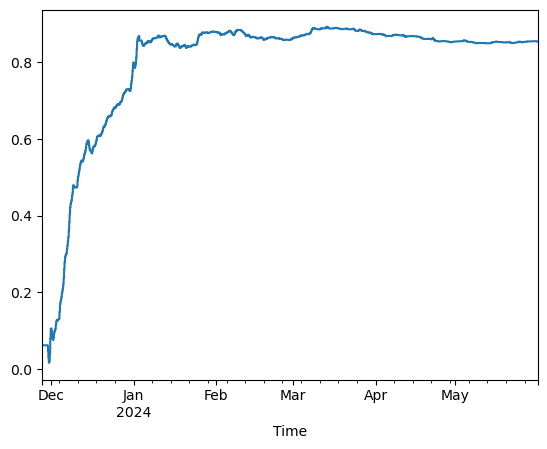

In [4]:
beta.plot()

In [8]:
beta[-1]

0.8546584440701436

In [5]:
beta = 0.85

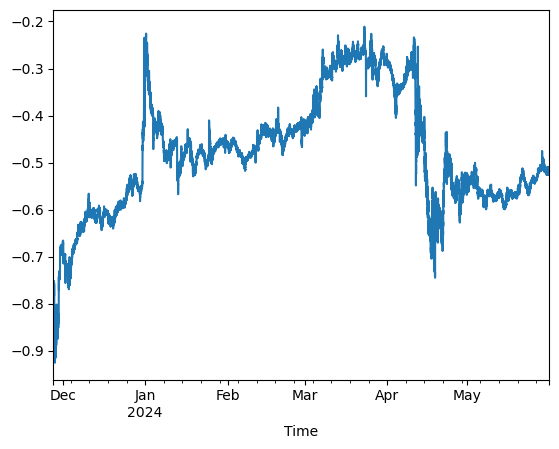

In [6]:
# Spread는 기본적으로 alpha (y-intercept)가 바뀌지 않을거라는 전제인듯. 

spread = pd.DataFrame()

# spread['Close'] = np.log(df1.Close)-np.log(df2.Close)*betas
spread['Close'] = np.log(df1.Close)-np.log(df2.Close)*beta
# spread['Close'] = df1.Close-df2.Close*beta

spread['barID'] = spread.reset_index().index.values

# vol2 = spread.Close.rolling(100).std()
vol1 = spread.Close.ewm(span = 100).std()
spread['vol'] = vol1


spread.Close.plot();plt.show()
zscore = getBollinger(spread.Close, lookback= 100, use_log = False)

In [37]:
minVol

0.0036

In [31]:
# Get Samples (events)
commission = 0.001
slippage = 0.0004*2 # Entry & Exit
minVol = (commission+slippage)*2
targetVol = 0.015
events = getCrossingEvents_dynamicExit(zscore, spread, entry_thres=-3, exit_thres1=0, entry_cross='downward', exit_cross1='upward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

lev_adj = targetVol/spread['vol'][events.index]

ret1 = get_lrets(events, df1, commission = commission+slippage, side='long', betSize = 1*lev_adj/4)
ret2 = get_lrets(events, df2, commission = commission+slippage, side='short', betSize = beta*lev_adj/4)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret

<Axes: >

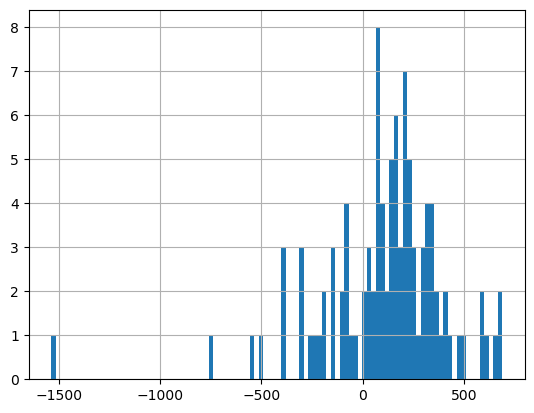

In [36]:
((np.exp(ret)-1)*45000).hist(bins=100)

<Axes: xlabel='Time'>

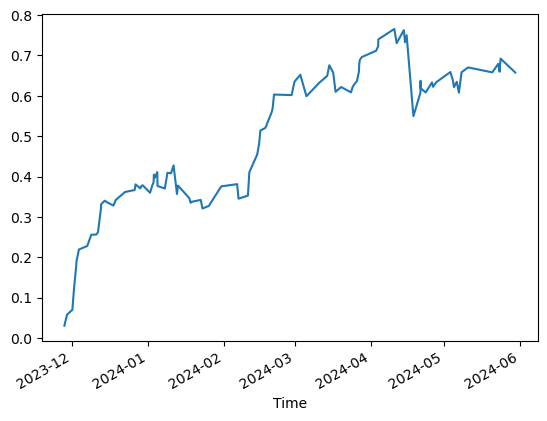

In [30]:
ret.cumsum().plot()

In [17]:
ret.sum()

-0.09229576211616695

<Axes: xlabel='Time'>

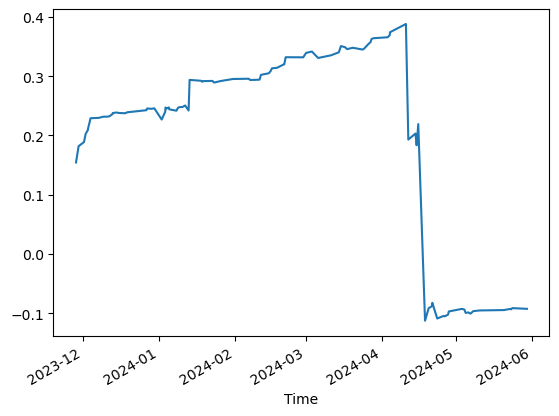

In [18]:
ret.cumsum().plot()

<Axes: >

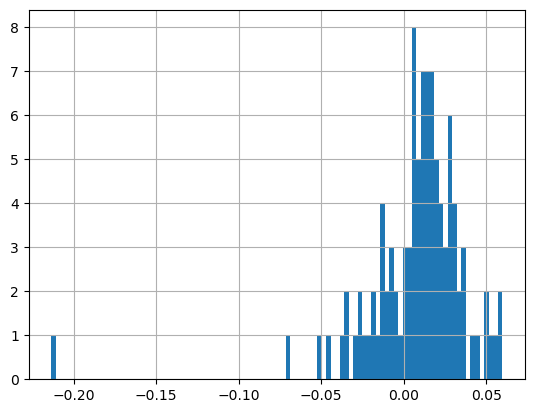

In [13]:
ret.hist(bins = 100)

0.0036

<Axes: xlabel='Time'>

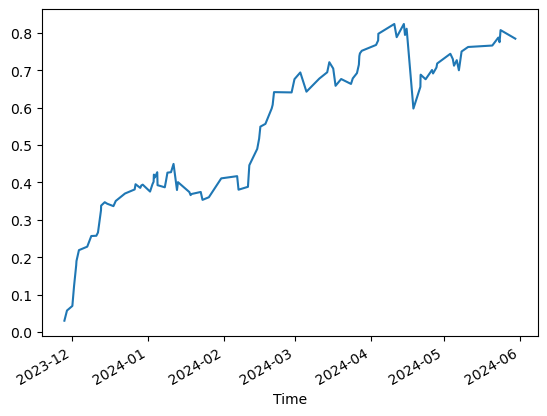

In [49]:
ret.cumsum().plot()

In [45]:
events_a = events.copy()

In [46]:
# Get Samples (events)
events = getCrossingEvents_dynamicExit(zscore, spread, entry_thres=3, exit_thres1=0, entry_cross='upward', exit_cross1='downward', 
                                       exit_thres2 = None, exit_cross2='downward', mid= 0, minVol = minVol,vol=spread['vol'])

ret1 = get_lrets(events, df1, commission = commission, side='short', betSize = 1)
ret2 = get_lrets(events, df2, commission = commission, side='long', betSize = beta)
ret = ret1 + ret2
events['ret1'] = ret1
events['ret2'] = ret2
events['ret'] = ret


lev_adj = spread['vol'][ret.index]/targetVol
ret = np.log((np.exp(ret)-1)/lev_adj + 1)
events['ret_adj'] = ret

<Axes: xlabel='Time'>

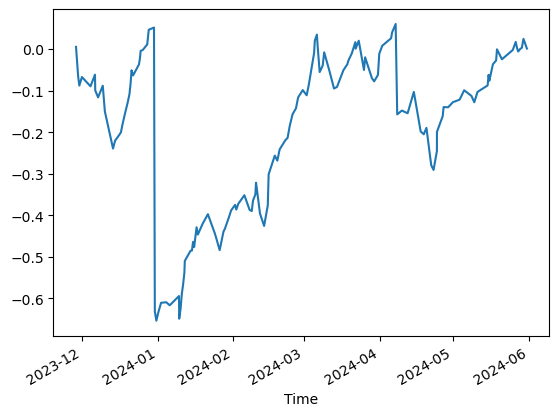

In [47]:
ret.cumsum().plot()

In [34]:
events_b = events.copy()

In [175]:
events_combined = pd.concat([events_a,events_b],axis = 0).sort_index()

In [176]:
events

,barID,t1,ret1,ret2,ret,ret_adj
Time,,,,,,
2023-11-29 12:40:00,572,2023-11-30 20:30:00,-0.007812,-0.105586,-0.113397,-0.060437
2023-12-01 01:10:00,1010,2023-12-01 06:00:00,-0.000551,0.010367,0.009816,0.013297
2023-12-03 14:05:00,1741,2023-12-04 00:00:00,-0.013085,0.051842,0.038757,0.028084
2023-12-06 09:45:00,2553,2023-12-07 03:05:00,-0.002735,-0.014245,-0.016981,-0.053304
2023-12-07 17:05:00,2929,2023-12-08 05:10:00,0.002343,0.006937,0.009280,0.022810
...,...,...,...,...,...,...
2024-05-18 14:50:00,49846,2024-05-19 08:35:00,0.011642,-0.014499,-0.002856,-0.008428
2024-05-20 01:15:00,50259,2024-05-20 15:00:00,-0.021203,0.014895,-0.006308,-0.014652
2024-05-24 14:00:00,51564,2024-05-24 22:50:00,-0.010294,0.013490,0.003196,0.008317


In [178]:
# Save Model
import pickle
with open('Analysis/[S3] ONT_ONG_Pair/events.pkl', 'wb') as f:
    pickle.dump(events_combined, f)

<Axes: xlabel='Time'>

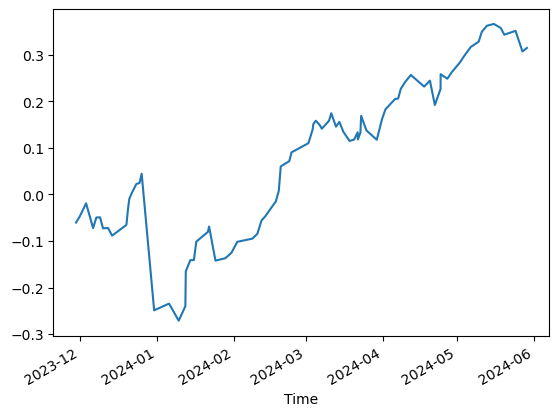

In [85]:
ret = pd.concat([ret_a, ret_b], axis = 0).sort_index()

<Axes: xlabel='Time'>

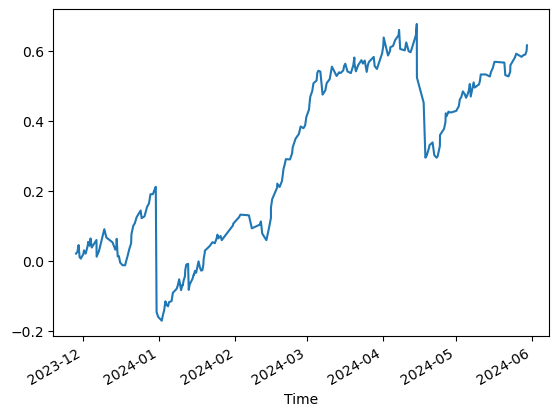

In [87]:
ret.cumsum().plot()

<Axes: xlabel='Time'>

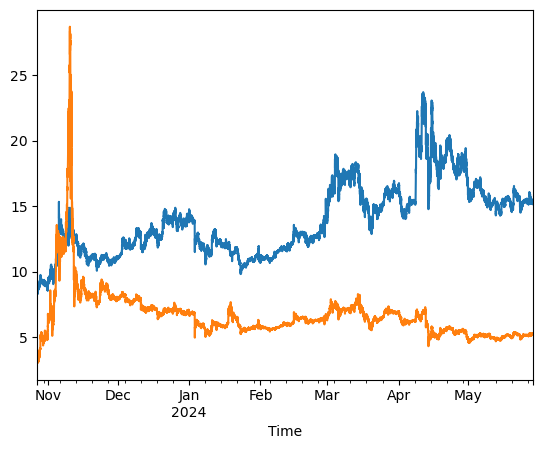

In [13]:
df1.Close[events.index[0]:events.t1[-1]].plot()
df2.Close[events.index[0]:events.t1[-1]].plot()

# 가설1: Low Depth

In [413]:
# 방법1: download the data first
depth1 = pd.read_csv(f'/Volumes/T7 Shield/data/depth/ONTUSDT_futures_depth_20231001_20240529.csv', index_col = 0)
depth2 = pd.read_csv(f'/Volumes/T7 Shield/data/depth/ONGUSDT_futures_depth_20231127_20240529.csv', index_col = 0)

In [414]:
depth1.timestamp = pd.to_datetime(depth1.timestamp)
depth2.timestamp = pd.to_datetime(depth2.timestamp)


In [415]:
temp1

,index,timestamp,percentage,depth,notional
0,6838960,2024-05-26 17:24:31,-5,3742013.1,1.121797e+06
1,6838961,2024-05-26 17:24:31,-4,3389463.6,1.018944e+06
2,6838962,2024-05-26 17:24:31,-3,2741713.0,8.277380e+05
3,6838963,2024-05-26 17:24:31,-2,2208605.7,6.689238e+05
4,6838964,2024-05-26 17:24:31,-1,1335063.2,4.058943e+05
5,6838965,2024-05-26 17:24:31,1,1225383.8,3.757889e+05
6,6838966,2024-05-26 17:24:31,2,1668577.0,5.131267e+05
7,6838967,2024-05-26 17:24:31,3,1949738.1,6.011216e+05
8,6838968,2024-05-26 17:24:31,4,2178303.5,6.733496e+05
9,6838969,2024-05-26 17:24:31,5,2350134.2,7.281951e+05


In [416]:
j = 4
k = 5
for t0 in events.index:
    idx = np.searchsorted(depth1.timestamp, t0)
    temp1 = depth1.iloc[idx-10:idx].reset_index()
    long = temp1.notional.iloc[j] + temp1.notional.iloc[k]

    idx = np.searchsorted(depth2.timestamp, t0)
    temp2 = depth2.iloc[idx-10:idx].reset_index()
    short = temp2.notional.iloc[j]/temp2.notional.iloc[k]

    ratio = (temp1.notional.iloc[j] + temp2.notional.iloc[k])/(temp1.notional.iloc[k]+temp2.notional.iloc[j])

    events.at[t0,'net_depth'] = ratio

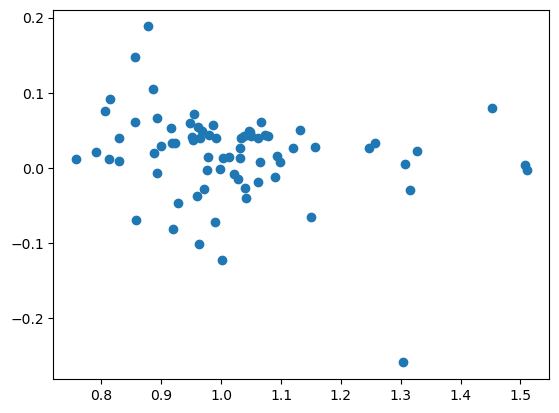

In [417]:
plt.scatter(events.net_depth, events.ret_adj)

In [269]:
iloc = np.argmin(events.ret)
event = events.iloc[iloc]

In [267]:
t0 = event.name - pd.Timedelta(days=60)
t1 = event.t1 + pd.Timedelta(days=30)

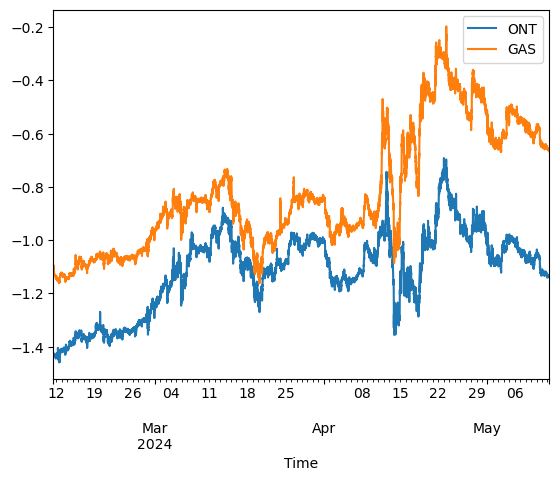

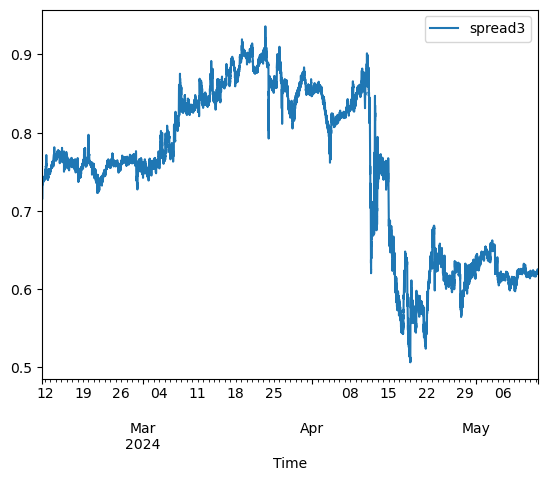

In [268]:
np.log(df1.Close)[t0:t1].plot(label = 'ONT')
# ax = plt.gca()
# df2.Close[t0:t1].plot(ax = ax, secondary_y=True, label ='GAS')
np.log(df2.Close)[t0:t1].plot(label ='GAS')
plt.legend()
plt.show()
# spread.Close[t0:t1].plot(label='spread1')

# spread2= np.log(df1.Close)-np.log(df2.Close)
# spread2[t0:t1].plot(label='spread2')

spread3= df1.Close/df2.Close
spread3[t0:t1].plot(label='spread3')
plt.legend()
plt.show()

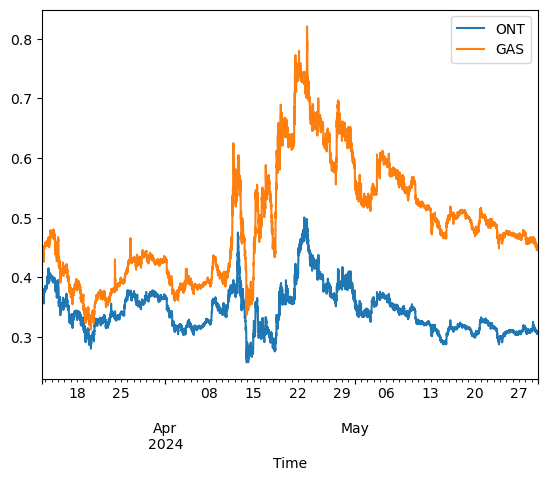

<Axes: xlabel='Time'>

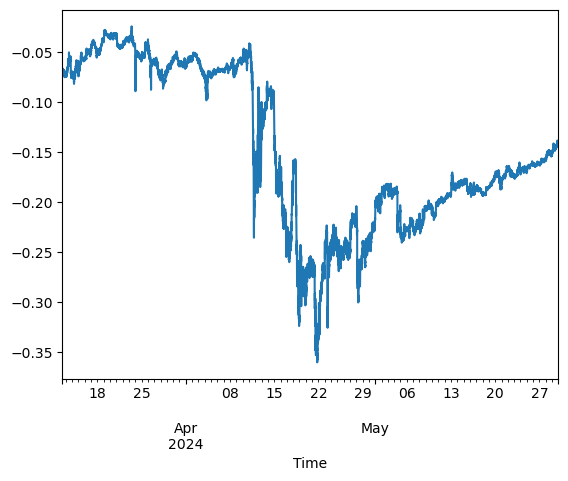

In [254]:
df1.Close[t0:].plot(label = 'ONT')
# ax = plt.gca()
# df2.Close[t0:t1].plot(ax = ax, secondary_y=True, label ='GAS')
df2.Close[t0:].plot(label ='GAS')
plt.legend()
plt.show()
spread.Close[t0:].plot()